In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_ks


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, return_hilbert_x0

from tools.ae_v1 import Autoencoder

from tools.ESN_v1 import ESN as RNN_SingleStep
from tools.ESN_v1_ensembleAR import ESN_ensemble as AR_RNN
from tools.AEESN_AR_v1 import AR_AERNN_ESN as AR_AERNN

from tools.hyper_param_ESN__NEWNEW import trainESN_and_return_PH

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-07-13 17:25:25.863976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 17:25:25.923540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 17:25:25.923839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 17:25:25.924950: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

# making RNN save directory
dir_name_rnn = os.getcwd() + dir_sep + 'ESN_params_Search'
if not os.path.isdir(dir_name_rnn):
    os.makedirs(dir_name_rnn)

counter = 0
while True:
    dir_check = 'params_search_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_rnn = dir_name_rnn + dir_sep + dir_check
os.makedirs(dir_name_rnn)
dir_name_rnn_plots = dir_name_rnn+dir_sep+'plots'
os.makedirs(dir_name_rnn_plots)

# whether to use AE data or just work on raw data
use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

# autoencoder directory
# ae_idx = '046'
# dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_000'.format(ds=dir_sep)

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_ks/ESN_params_Search/params_search_001
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_000
data_dir_idx: 000
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500026]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

time_stddev_ogdata = np.std(all_data[:, 0:og_vars], axis=0)
time_mean_ogdata = np.mean(all_data[:, 0:og_vars], axis=0)
    
if use_ae_data == True:
    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
        normalization_constant_arr_aedata = normalization_constant_arr_aedata[:, 0:og_vars]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:og_vars]
    normalization_constant_arr_aedata = normalization_constant_arr_aedata[:, 0:og_vars]

# Autoencoder

In [21]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [22]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [23]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    # del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

# GRU

In [24]:
# RNN data parameters
dt_rnn = 0.2
num_input_tsteps = 22000
T_sample_input = num_input_tsteps*dt_rnn
T_sample_output = T_sample_input
T_offset = dt_rnn
normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
normalization_arr = None
stddev_multiplier = 3
skip_intermediate = 'full sample'
noise_type = 'normal' # can be 'uniform' or 'normal'
normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                              # 'minmax' then stddev_multiplier has no effect
ESN_layers_units = [num_latent_states*200]
stateful = True
omega_in_x0 = 1.0
degree_of_connectivity_x0 = 3
rho_res_x0 = 0.8
usebias_Win = [False]
alpha_x0 = 0.99
ESN_cell_activations = ['tanh']
usebias_Wout = True

activation_post_Wout = 'linear'
use_weights_post_dense = False

vary_deg_connect = False # whether to search for degree_of_connectivity or use it as a constant

if return_params_arr != False:
    params = params_arr
else:
    params = None

# saving simulation data
sim_data = {
    'params_mat':params_mat,
    'init_state_mat':init_state_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'return_params_arr':return_params_arr,
    'dir_name_ae':dir_name_ae,
    'normalize_dataset':normalize_dataset,
    'stddev_multiplier':stddev_multiplier,
    'use_ae_data':use_ae_data,
    'vary_deg_connect':vary_deg_connect,
}

# saving RNN specific data
RNN_specific_data = {
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'params':params,
    'return_params_arr':return_params_arr,
    'normalize_dataset':normalize_dataset,
    'num_input_tsteps':num_input_tsteps,
    'stddev_multiplier':stddev_multiplier,
    'skip_intermediate':skip_intermediate,
    'module':RNN_SingleStep.__module__,
    'noise_type':noise_type,
    'normalization_type':normalization_type,
}

In [25]:
# latent_states_all = latent_states_all[0:375009]
# boundary_idx_arr = [375009]

In [26]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [27]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [28]:
rnn_res_dict = create_data_for_RNN(
    all_data,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=False,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
AR_data_rnn_input = rnn_res_dict['data_rnn_input']
AR_data_rnn_output = rnn_res_dict['data_rnn_output']
AR_org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
AR_org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
AR_num_samples = rnn_res_dict['num_samples']
AR_normalization_arr = rnn_res_dict['normalization_arr']
AR_rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

del(AR_org_data_idx_arr_input)
del(AR_org_data_idx_arr_output)
del(AR_rnn_data_boundary_idx_arr)

In [29]:
# setting up training params
num_ensemble_mems = 5
epochs = 1
lambda_reg_x0 = 1e-7 # weight for regularizer
min_delta = 1e-6
patience = 5
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 1
fRMS_x0 = 1e-3
use_best = False

# ph computation parameters
num_runs = 50
T_sample_input_AR_ratio = 1
T_sample_output_AR_ratio = 5

# saving training params
training_specific_params = {
    'epochs':epochs,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'fRMS':fRMS,
    'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
    # 'stddev':stddev,
    # 'lambda_reg':lambda_reg,
    'min_delta':min_delta,
    'patience':patience,
    'use_best':use_best,
    'degree_of_connectivity_x0':degree_of_connectivity_x0,
}

In [30]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = batch_size * int((rnn_data_boundary_idx_arr[i] - begin_idx) // batch_size)
    num_train_arr[i] = batch_size * int( np.round(train_split*num_samples/batch_size) )
    num_val_arr[i] = batch_size * int( np.round(val_split*num_samples/batch_size) )
    num_test_arr[i] = batch_size * int( np.round((num_samples - num_train_arr[i] - num_val_arr[i])/batch_size) )
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

AR_testing_data_rnn_input = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)
AR_testing_data_rnn_output = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( np.round(train_split*num_samples/batch_size) )*batch_size
    # num_val = int( np.round(val_split*num_samples/batch_size) )*batch_size
    
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]

    AR_testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = AR_data_rnn_input[idx[num_train+num_val:num_samples]]
    AR_testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = AR_data_rnn_output[idx[num_train+num_val:num_samples]]

    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)
del(AR_data_rnn_input)
del(AR_data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [31]:
s_in = AR_testing_data_rnn_input.shape
AR_testing_data_rnn_input = AR_testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = AR_testing_data_rnn_output.shape
AR_testing_data_rnn_output = AR_testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

T_sample_input_AR = T_sample_input_AR_ratio*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = T_sample_output_AR_ratio*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
maxpossible_num_runs = AR_testing_data_rnn_input.shape[1]-(num_sample_input_AR+num_sample_output_AR)

num_runs = np.min([num_runs, maxpossible_num_runs])

print('num_runs : ', num_runs)

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

num_runs :  50


In [32]:
AR_data_in = np.empty(shape=(num_runs, num_sample_input_AR)+tuple(s_in[2:]))
AR_data_out = np.empty(shape=(num_runs, num_sample_output_AR)+tuple(s_out[2:]))

for i in range(num_runs):
    d_idx = data_idx_arr[i]
    AR_data_in[i] = AR_testing_data_rnn_input[0, d_idx:d_idx+num_sample_input_AR]
    AR_data_out[i] = AR_testing_data_rnn_input[0, d_idx+num_sample_input_AR:d_idx+num_sample_input_AR+num_sample_output_AR]

In [33]:
del(AR_testing_data_rnn_input)
del(AR_testing_data_rnn_output)
AR_testing_data_rnn_input = AR_data_in
AR_testing_data_rnn_output = AR_data_out

In [34]:
print('   training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print('  training_data_rnn_output.shape : ', training_data_rnn_output.shape)
print('    testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('   testing_data_rnn_output.shape : ', testing_data_rnn_output.shape)
print('        val_data_rnn_input.shape : ', val_data_rnn_input.shape)
print('       val_data_rnn_output.shape : ', val_data_rnn_output.shape)
print('')
print(' AR_testing_data_rnn_input.shape : ', AR_testing_data_rnn_input.shape)
print('AR_testing_data_rnn_output.shape : ', AR_testing_data_rnn_output.shape)

   training_data_rnn_input.shape :  (9, 22000, 16)
  training_data_rnn_output.shape :  (9, 22000, 16)
    testing_data_rnn_input.shape :  (1, 22000, 16)
   testing_data_rnn_output.shape :  (1, 22000, 16)
        val_data_rnn_input.shape :  (1, 22000, 16)
       val_data_rnn_output.shape :  (1, 22000, 16)

 AR_testing_data_rnn_input.shape :  (50, 77, 64)
AR_testing_data_rnn_output.shape :  (50, 387, 64)


In [35]:
training_data_rnn_input.dtype

dtype('float32')

In [36]:
def optim_func(
        x, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev=time_stddev,
        og_vars=og_vars,
        ESN=RNN_SingleStep,
        AR_RNN=AR_RNN,
        AR_AERNN=AR_AERNN,
        ae_net=ae_net,
        mytimecallback=mytimecallback,
        SaveLosses=SaveLosses,
        plot_losses=plot_losses,
        dir_name_rnn=dir_name_rnn,
        boundary_idx_arr=boundary_idx_arr,
        lyapunov_time_arr=lyapunov_time_arr,
        sim_data_dict=sim_data,
        RNN_specific_data_dict=RNN_specific_data,
        training_specific_params_dict=training_specific_params,
        normalization_arr=normalization_arr,
        training_data_rnn_input=training_data_rnn_input,
        training_data_rnn_output=training_data_rnn_output,
        testing_data_rnn_input=testing_data_rnn_input,
        testing_data_rnn_output=testing_data_rnn_output,
        val_data_rnn_input=val_data_rnn_input,
        val_data_rnn_output=val_data_rnn_output,
        AR_testing_data_rnn_input=AR_testing_data_rnn_input,
        AR_testing_data_rnn_output=AR_testing_data_rnn_output,
        return_params_arr=return_params_arr,
        normalize_dataset=normalize_dataset,
        dt_rnn=dt_rnn,
        noise_type=noise_type,
        ae_data_normalization_arr=normalization_constant_arr_aedata,
        time_stddev_ogdata=time_stddev_ogdata,
        time_mean_ogdata=time_mean_ogdata,
        T_sample_input=T_sample_input_AR,
        T_sample_output=T_sample_output_AR,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
        deg_of_connectivity=degree_of_connectivity_x0,
    ):
    
    compute_time = time.time()
    
    x_in = x
    if len(x) == 5:
        x_in = [elem for elem in x]
        x_in.append(deg_of_connectivity)

    median_PH = trainESN_and_return_PH(
        x_in, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev,
        og_vars,
        ESN,
        AR_RNN,
        AR_AERNN,
        ae_net,
        mytimecallback,
        SaveLosses,
        plot_losses,
        dir_name_rnn,
        boundary_idx_arr,
        lyapunov_time_arr,
        sim_data_dict,
        RNN_specific_data_dict,
        training_specific_params_dict,
        normalization_arr,
        training_data_rnn_input,
        training_data_rnn_output,
        testing_data_rnn_input,
        testing_data_rnn_output,
        val_data_rnn_input,
        val_data_rnn_output,
        AR_testing_data_rnn_input,
        AR_testing_data_rnn_output,
        return_params_arr,
        normalize_dataset,
        dt_rnn,
        noise_type,
        ae_data_normalization_arr,
        time_stddev_ogdata,
        time_mean_ogdata,
        T_sample_input,
        T_sample_output,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
    )
    
    compute_time = time.time() - compute_time
    print('compute_time : {:.0f}h {:.0f}m {:.0f}s'.format(
        float(compute_time // 3600),
        float((compute_time%3600)//60),
        float((compute_time%3600)%60),
    ))
    
    return -median_PH

In [37]:
x_bounds = [
    [1e-4, 1e-1, "log-uniform", "Real"], # fRMS
    [1e-7, 1e-3, "log-uniform", "Real"], # lambda_reg
    [0.2, 1.2, "uniform", "Real"], # rho_res
    [0.1, 2.5, "uniform", "Real"], # omega_in
    [0.5, 1.0, "uniform", "Real"], # alpha
]
if vary_deg_connect == True:
    x_bounds.append([1, 10, "uniform", "Integer"])

In [38]:
h_dims = len(x_bounds)
num_points = 10*h_dims
# num_points = 2

h_order = 0
while(True):
    if 2**(h_dims*h_order) >= num_points:
        break
    else:
        h_order += 1

print('h_dims : {} ; num_points : {} ; h_order : {}'.format(h_dims, num_points, h_order))

h_dims : 5 ; num_points : 50 ; h_order : 2


In [39]:
locs = return_hilbert_x0(num_points, h_dims, h_order)
# print(locs)
locs = np.array(locs, dtype=np.float64)
locs /= 2**h_order-1
# print(locs)

for i in range(h_dims):
    x1 = x_bounds[i][0]
    x2 = x_bounds[i][1]
    if x_bounds[i][2] == "log-uniform":
        x1 = np.log10(x1)
        x2 = np.log10(x2)
    spread = x2 - x1
    locs[:, i] *= spread
    locs[:, i] += x1
    if x_bounds[i][2] == "log-uniform":
        locs[:, i] = 10**(locs[:, i])

# print(locs)

In [40]:
dimensions = [
    eval(elem[3])(*elem[0:3]) for elem in x_bounds
]

In [41]:
print(locs)

x0 = [
    [elem2 for elem2 in elem1] for elem1 in locs
]

print(x0)

[[1.00000000e-04 1.00000000e-07 2.00000000e-01 1.00000000e-01
  5.00000000e-01]
 [1.00000000e-03 2.15443469e-06 5.33333333e-01 1.00000000e-01
  6.66666667e-01]
 [1.00000000e-03 2.15443469e-06 2.00000000e-01 1.00000000e-01
  8.33333333e-01]
 [1.00000000e-04 1.00000000e-07 5.33333333e-01 9.00000000e-01
  1.00000000e+00]
 [1.00000000e-03 1.00000000e-07 5.33333333e-01 1.70000000e+00
  1.00000000e+00]
 [1.00000000e-04 2.15443469e-06 2.00000000e-01 1.70000000e+00
  6.66666667e-01]
 [1.00000000e-04 2.15443469e-06 2.00000000e-01 2.50000000e+00
  5.00000000e-01]
 [1.00000000e-03 1.00000000e-07 8.66666667e-01 1.70000000e+00
  5.00000000e-01]
 [1.00000000e-04 1.00000000e-07 8.66666667e-01 2.50000000e+00
  8.33333333e-01]
 [1.00000000e-04 2.15443469e-06 1.20000000e+00 1.70000000e+00
  8.33333333e-01]
 [1.00000000e-03 1.00000000e-07 8.66666667e-01 9.00000000e-01
  8.33333333e-01]
 [1.00000000e-04 2.15443469e-06 8.66666667e-01 9.00000000e-01
  6.66666667e-01]
 [1.00000000e-03 1.00000000e-07 1.200000

In [42]:
acq_func = "EI"
n_initial_points = 0
n_calls = n_initial_points + len(x0) + 20

In [43]:
optim_dict = {
    'fRMS_bounds':x_bounds[0],
    'lambda_reg_bounds':x_bounds[1],
    'rho_res_bounds':x_bounds[2],
    'omega_in_bounds':x_bounds[3],
    'alpha_bounds':x_bounds[4],
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
    'vary_deg_connect':vary_deg_connect,
}
if vary_deg_connect == True:
    optim_dict['vary_deg_connect'] = x_bounds[5]
with open(dir_name_rnn + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))

In [44]:
res = gp_minimize(
    optim_func,
    dimensions,
    x0=x0,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.82 s -- eta : 0h 0m 39s
2 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 5.02 s -- eta : 0h 0m 28s
4 / 9 -- Wout batch_time : 5.11 s -- eta : 0h 0m 24s
5 / 9 -- Wout batch_time : 4.28 s -- eta : 0h 0m 19s
6 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 14s
7 / 9 -- Wout batch_time : 4.56 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.57 s -- eta : 0h 0m 5s
9 / 9 -- Wout batch_time : 4.60 s -- eta : 0h 0m 0s

epoch_time : 42.66105246543884 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 42.67803621292114 sec

test mse
1 / 1
test_mse : 3.6581473068508785e-06
--- ENSEMBLE MEMBER 2/5 ---


----------------------

6 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 14s
7 / 9 -- Wout batch_time : 4.46 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.65 s -- eta : 0h 0m 5s
9 / 9 -- Wout batch_time : 4.62 s -- eta : 0h 0m 0s

epoch_time : 41.902053117752075 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 41.918697118759155 sec

test mse
1 / 1
test_mse : 3.456159674897208e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.31 s -- eta : 0h 0m 34s
2 / 9 -- Wout batch_time : 4.45 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.42 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.37 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.23 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.38 s -- eta : 0h 0m 13

1 / 9 -- Wout batch_time : 4.65 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.43 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.14 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.68 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.50 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.63 s -- eta : 0h 0m 14s
7 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.46 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.53 s -- eta : 0h 0m 0s

epoch_time : 41.50249171257019 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 41.51911997795105 sec

test mse
1 / 1
test_mse : 4.323446319176583e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.62 s -- eta : 0h 0m 37s


test_mse : 7.387117875623517e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.62 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.59 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.79 s -- eta : 0h 0m 28s
4 / 9 -- Wout batch_time : 4.15 s -- eta : 0h 0m 23s
5 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.38 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.28 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.13 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 0s

epoch_time : 40.695512771606445 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.723220109939575 sec

test mse
1 / 1
test_mse : 6.505103101517307e-06
--- ENSEMBLE MEMBE

6 / 9 -- Wout batch_time : 4.20 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.18 s -- eta : 0h 0m 8s
8 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.22 s -- eta : 0h 0m 0s

epoch_time : 39.30430316925049 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 39.32132291793823 sec

test mse
1 / 1
test_mse : 2.497721879990422e-06
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.57 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.30 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.14 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.19 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.42 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.22 s -- eta : 0h 0m 13s


1 / 9 -- Wout batch_time : 4.25 s -- eta : 0h 0m 34s
2 / 9 -- Wout batch_time : 5.23 s -- eta : 0h 0m 33s
3 / 9 -- Wout batch_time : 4.19 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 23s
5 / 9 -- Wout batch_time : 4.45 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.62 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.18 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.33 s -- eta : 0h 0m 0s

epoch_time : 41.04707670211792 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 41.06370282173157 sec

test mse
1 / 1
test_mse : 3.1381994176626904e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.26 s -- eta : 0h 0m 34s

test_mse : 3.762770802495652e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 36s
2 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.28 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.07 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.37 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.14 s -- eta : 0h 0m 0s

epoch_time : 39.866228342056274 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 39.8903021812439 sec

test mse
1 / 1
test_mse : 3.834689323412022e-06
tested_rnn/test_rnn_

6 / 9 -- Wout batch_time : 4.21 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.22 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.55 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 0s

epoch_time : 40.61805462837219 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.64038968086243 sec

test mse
1 / 1
test_mse : 7.739363354630768e-06
tested_rnn/test_rnn_007
num_runs : 50
    1 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    1

analysis time : 15.41763949394226 s

compute_time : 0h 3m 52s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.59 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.42 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.30 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.25 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.50 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.50 s -- eta : 0h 0m 0s

epoch_time : 40.766539573669434 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.78321361541748 sec

test mse
1 / 1
test_mse : 1.0211932021

5 / 9 -- Wout batch_time : 4.46 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.24 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.43 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.38 s -- eta : 0h 0m 0s

epoch_time : 41.0850465297699 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 41.10175395011902 sec

test mse
1 / 1
test_mse : 2.6088791855727322e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.59 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.45 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.29 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.08 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 17s


1 / 9 -- Wout batch_time : 4.28 s -- eta : 0h 0m 34s
2 / 9 -- Wout batch_time : 4.24 s -- eta : 0h 0m 30s
3 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.55 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.58 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.55 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.42 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.14 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.52 s -- eta : 0h 0m 0s

epoch_time : 40.8149893283844 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.84333252906799 sec

test mse
1 / 1
test_mse : 3.4344948289799504e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 35s


test_mse : 1.770289418345783e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.42 s -- eta : 0h 0m 35s
2 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.33 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.28 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.33 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.48 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.58 s -- eta : 0h 0m 0s

epoch_time : 40.52625584602356 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.5528883934021 sec

test mse
1 / 1
test_mse : 2.171058986277785e-05
--- ENSEMBLE MEMBER 4

6 / 9 -- Wout batch_time : 4.59 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.44 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.54 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.25 s -- eta : 0h 0m 0s

epoch_time : 41.08012843132019 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 41.09728455543518 sec

test mse
1 / 1
test_mse : 2.2564048776985146e-05
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.64 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.54 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.21 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.15 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 13s

1 / 9 -- Wout batch_time : 4.73 s -- eta : 0h 0m 38s
2 / 9 -- Wout batch_time : 4.42 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.24 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.27 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.65 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.61 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.59 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 0s

epoch_time : 41.46030521392822 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 41.48392868041992 sec

test mse
1 / 1
test_mse : 3.4434219742252026e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.60 s -- eta : 0h 0m 37s

test_mse : 2.7753974336519605e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.74 s -- eta : 0h 0m 38s
2 / 9 -- Wout batch_time : 4.43 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.38 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.46 s -- eta : 0h 0m 23s
5 / 9 -- Wout batch_time : 4.28 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.46 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.60 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.51 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 0s

epoch_time : 41.29062294960022 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 41.307775020599365 sec

test mse
1 / 1
test_mse : 2.87816442323674e-06
tested_rnn/test_rnn

6 / 9 -- Wout batch_time : 4.50 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.48 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.16 s -- eta : 0h 0m 0s

epoch_time : 41.03149461746216 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 41.06343483924866 sec

test mse
1 / 1
test_mse : 1.0592357284622267e-05
tested_rnn/test_rnn_016
num_runs : 50
    1 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    

analysis time : 15.354666233062744 s

compute_time : 0h 3m 56s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.56 s -- eta : 0h 0m 36s
2 / 9 -- Wout batch_time : 4.52 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.44 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.38 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.22 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.53 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.66 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.42 s -- eta : 0h 0m 0s

epoch_time : 41.162672996520996 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 41.179367780685425 sec

test mse
1 / 1
test_mse : 7.78814865

5 / 9 -- Wout batch_time : 4.59 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.18 s -- eta : 0h 0m 14s
7 / 9 -- Wout batch_time : 4.54 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.51 s -- eta : 0h 0m 5s
9 / 9 -- Wout batch_time : 4.51 s -- eta : 0h 0m 0s

epoch_time : 41.77415704727173 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 41.79096031188965 sec

test mse
1 / 1
test_mse : 4.024568625027314e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.58 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.46 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.52 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.44 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.23 s -- eta : 0h 0m 18s


1 / 9 -- Wout batch_time : 4.75 s -- eta : 0h 0m 38s
2 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.23 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.59 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.33 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.33 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.18 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 0s

epoch_time : 40.596097230911255 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.61858558654785 sec

test mse
1 / 1
test_mse : 2.975448978759232e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.22 s -- eta : 0h 0m 34s

test_mse : 2.6026389150501927e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.05 s -- eta : 0h 0m 32s
2 / 9 -- Wout batch_time : 4.26 s -- eta : 0h 0m 29s
3 / 9 -- Wout batch_time : 4.46 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.31 s -- eta : 0h 0m 21s
5 / 9 -- Wout batch_time : 4.19 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.47 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.45 s -- eta : 0h 0m 0s

epoch_time : 39.87143015861511 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 39.88792133331299 sec

test mse
1 / 1
test_mse : 2.566111106716562e-06
--- ENSEMBLE MEMBER

6 / 9 -- Wout batch_time : 4.22 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.25 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.07 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.20 s -- eta : 0h 0m 0s

epoch_time : 39.47925162315369 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 39.50604271888733 sec

test mse
1 / 1
test_mse : 1.788051804396673e-06
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.18 s -- eta : 0h 0m 33s
2 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 30s
3 / 9 -- Wout batch_time : 4.29 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 3.95 s -- eta : 0h 0m 21s
5 / 9 -- Wout batch_time : 4.16 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 13s


1 / 9 -- Wout batch_time : 4.52 s -- eta : 0h 0m 36s
2 / 9 -- Wout batch_time : 4.14 s -- eta : 0h 0m 30s
3 / 9 -- Wout batch_time : 4.17 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.42 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.26 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.21 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.34 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.46 s -- eta : 0h 0m 0s

epoch_time : 39.89353084564209 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 39.91059899330139 sec

test mse
1 / 1
test_mse : 5.141808742337162e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.27 s -- eta : 0h 0m 34s


test_mse : 4.0070785871648695e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.60 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.13 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.56 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.18 s -- eta : 0h 0m 0s

epoch_time : 40.3336296081543 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.363486528396606 sec

test mse
1 / 1
test_mse : 4.089038611709839e-06
tested_rnn/test_rnn

6 / 9 -- Wout batch_time : 4.30 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.28 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.56 s -- eta : 0h 0m 0s

epoch_time : 40.532532691955566 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.54942202568054 sec

test mse
1 / 1
test_mse : 6.466920240200125e-06
tested_rnn/test_rnn_025
num_runs : 50
    1 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    

analysis time : 15.44344973564148 s

compute_time : 0h 3m 53s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.66 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.57 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.51 s -- eta : 0h 0m 23s
5 / 9 -- Wout batch_time : 4.23 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.28 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.53 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.63 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 0s

epoch_time : 41.111058473587036 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 41.12785840034485 sec

test mse
1 / 1
test_mse : 8.2888378528

5 / 9 -- Wout batch_time : 4.28 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.04 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.26 s -- eta : 0h 0m 8s
8 / 9 -- Wout batch_time : 4.22 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.44 s -- eta : 0h 0m 0s

epoch_time : 39.39932060241699 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 39.41596555709839 sec

test mse
1 / 1
test_mse : 4.908486971544335e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.58 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.23 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.02 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.27 s -- eta : 0h 0m 21s
5 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 17s


1 / 9 -- Wout batch_time : 4.44 s -- eta : 0h 0m 36s
2 / 9 -- Wout batch_time : 4.83 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.38 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.29 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 5.60 s -- eta : 0h 0m 19s
6 / 9 -- Wout batch_time : 4.86 s -- eta : 0h 0m 14s
7 / 9 -- Wout batch_time : 5.13 s -- eta : 0h 0m 10s
8 / 9 -- Wout batch_time : 4.55 s -- eta : 0h 0m 5s
9 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 0s

epoch_time : 43.775662422180176 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 43.80418062210083 sec

test mse
1 / 1
test_mse : 6.309400760073913e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.58 s -- eta : 0h 0m 37

test_mse : 5.3272084187483415e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.67 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.23 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.31 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.21 s -- eta : 0h 0m 0s

epoch_time : 40.76517939567566 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.79559826850891 sec

test mse
1 / 1
test_mse : 5.307843457558192e-05
--- ENSEMBLE MEMBER

6 / 9 -- Wout batch_time : 4.18 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.28 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.43 s -- eta : 0h 0m 0s

epoch_time : 39.77356696128845 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 39.790539026260376 sec

test mse
1 / 1
test_mse : 7.620012911502272e-05
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.44 s -- eta : 0h 0m 35s
2 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.15 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.22 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.56 s -- eta : 0h 0m 13s

1 / 9 -- Wout batch_time : 4.60 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.42 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.48 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.23 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.20 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.51 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 0s

epoch_time : 40.7269287109375 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.743558168411255 sec

test mse
1 / 1
test_mse : 1.1211136552446987e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.55 s -- eta : 0h 0m 36s

test_mse : 1.1600871403061319e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.64 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.50 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.25 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.14 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.50 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.59 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.12 s -- eta : 0h 0m 0s

epoch_time : 40.870768785476685 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.90594410896301 sec

test mse
1 / 1
test_mse : 1.238774711964652e-05
tested_rnn/test_rn

6 / 9 -- Wout batch_time : 4.46 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.47 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.28 s -- eta : 0h 0m 0s

epoch_time : 40.529035568237305 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.55290746688843 sec

test mse
1 / 1
test_mse : 0.00017326127272099257
tested_rnn/test_rnn_034
num_runs : 50
    1 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
   

analysis time : 15.368696212768555 s

compute_time : 0h 3m 54s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.58 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.31 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.31 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.52 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.38 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.37 s -- eta : 0h 0m 0s

epoch_time : 40.722437143325806 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.73927569389343 sec

test mse
1 / 1
test_mse : 7.191402983

5 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.48 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.43 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.20 s -- eta : 0h 0m 0s

epoch_time : 40.67784094810486 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.694193601608276 sec

test mse
1 / 1
test_mse : 2.0482641048147343e-05
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.69 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.11 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.38 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.43 s -- eta : 0h 0m 18

1 / 9 -- Wout batch_time : 4.54 s -- eta : 0h 0m 36s
2 / 9 -- Wout batch_time : 4.31 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.12 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.43 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.50 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.61 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.38 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.12 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 0s

epoch_time : 40.79621601104736 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.81357383728027 sec

test mse
1 / 1
test_mse : 2.056663652183488e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.68 s -- eta : 0h 0m 37s


test_mse : 7.776798156555742e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 35s
2 / 9 -- Wout batch_time : 4.43 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.48 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.61 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.09 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.27 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.31 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 0s

epoch_time : 40.32423520088196 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.35338830947876 sec

test mse
1 / 1
test_mse : 7.363492477452382e-05
--- ENSEMBLE MEMBER 

6 / 9 -- Wout batch_time : 4.42 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.43 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.51 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.44 s -- eta : 0h 0m 0s

epoch_time : 40.64477348327637 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.672075271606445 sec

test mse
1 / 1
test_mse : 7.071457275742432e-06
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.82 s -- eta : 0h 0m 39s
2 / 9 -- Wout batch_time : 4.45 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.51 s -- eta : 0h 0m 28s
4 / 9 -- Wout batch_time : 4.54 s -- eta : 0h 0m 23s
5 / 9 -- Wout batch_time : 4.16 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.50 s -- eta : 0h 0m 13s

1 / 9 -- Wout batch_time : 4.29 s -- eta : 0h 0m 34s
2 / 9 -- Wout batch_time : 4.38 s -- eta : 0h 0m 30s
3 / 9 -- Wout batch_time : 4.45 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.52 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.24 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.18 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.42 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.58 s -- eta : 0h 0m 0s

epoch_time : 40.434221506118774 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.454866886138916 sec

test mse
1 / 1
test_mse : 0.00016012137348297983
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.74 s -- eta : 0h 0m 3

test_mse : 0.00011973008076893166
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.55 s -- eta : 0h 0m 36s
2 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.21 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.44 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.44 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.19 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.42 s -- eta : 0h 0m 0s

epoch_time : 40.54166626930237 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.55856943130493 sec

test mse
1 / 1
test_mse : 0.00012596038868650794
tested_rnn/test_rn

6 / 9 -- Wout batch_time : 4.16 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.20 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.57 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 0s

epoch_time : 40.3944833278656 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.41125416755676 sec

test mse
1 / 1
test_mse : 1.190215061797062e-05
tested_rnn/test_rnn_043
num_runs : 50
    1 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    12

analysis time : 15.360209465026855 s

compute_time : 0h 3m 55s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.68 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.21 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.34 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.43 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.47 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.53 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 0s

epoch_time : 40.9189133644104 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.93558979034424 sec

test mse
1 / 1
test_mse : 5.31261284777

5 / 9 -- Wout batch_time : 4.19 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.33 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.38 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 0s

epoch_time : 39.75694251060486 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 39.773563623428345 sec

test mse
1 / 1
test_mse : 6.422427759389393e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.70 s -- eta : 0h 0m 38s
2 / 9 -- Wout batch_time : 4.29 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.08 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.29 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 17s

1 / 9 -- Wout batch_time : 4.99 s -- eta : 0h 0m 40s
2 / 9 -- Wout batch_time : 4.54 s -- eta : 0h 0m 33s
3 / 9 -- Wout batch_time : 4.73 s -- eta : 0h 0m 28s
4 / 9 -- Wout batch_time : 4.73 s -- eta : 0h 0m 24s
5 / 9 -- Wout batch_time : 4.67 s -- eta : 0h 0m 19s
6 / 9 -- Wout batch_time : 4.10 s -- eta : 0h 0m 14s
7 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 5s
9 / 9 -- Wout batch_time : 4.55 s -- eta : 0h 0m 0s

epoch_time : 42.18763279914856 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 42.2150022983551 sec

test mse
1 / 1
test_mse : 4.2335381294833496e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.56 s -- eta : 0h 0m 36s


test_mse : 5.465905815071892e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.63 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.44 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.29 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.37 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.54 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.56 s -- eta : 0h 0m 0s

epoch_time : 41.04077363014221 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 41.07057309150696 sec

test mse
1 / 1
test_mse : 5.453140147437807e-06
--- ENSEMBLE MEMBER 

6 / 9 -- Wout batch_time : 4.13 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.44 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.29 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 0s

epoch_time : 40.26017951965332 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.292744159698486 sec

test mse
1 / 1
test_mse : 4.504585831455188e-06
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.73 s -- eta : 0h 0m 38s
2 / 9 -- Wout batch_time : 4.58 s -- eta : 0h 0m 33s
3 / 9 -- Wout batch_time : 4.47 s -- eta : 0h 0m 28s
4 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 23s
5 / 9 -- Wout batch_time : 4.34 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.34 s -- eta : 0h 0m 13s

1 / 9 -- Wout batch_time : 4.64 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.13 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.30 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.07 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.53 s -- eta : 0h 0m 0s

epoch_time : 40.179771900177 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.201470375061035 sec

test mse
1 / 1
test_mse : 3.352234489284456e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.12 s -- eta : 0h 0m 33s
2

test_mse : 6.386570748873055e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.25 s -- eta : 0h 0m 34s
2 / 9 -- Wout batch_time : 4.38 s -- eta : 0h 0m 30s
3 / 9 -- Wout batch_time : 4.50 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.45 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.15 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.16 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.43 s -- eta : 0h 0m 0s

epoch_time : 40.03639578819275 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.05330491065979 sec

test mse
1 / 1
test_mse : 6.467063212767243e-05
tested_rnn/test_rnn_

6 / 9 -- Wout batch_time : 4.51 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.51 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.34 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.26 s -- eta : 0h 0m 0s

epoch_time : 41.12478280067444 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 41.14306712150574 sec

test mse
1 / 1
test_mse : 3.702332833199762e-05
tested_rnn/test_rnn_052
num_runs : 50
    1 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    1

analysis time : 16.62683653831482 s

compute_time : 0h 4m 1s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.57 s -- eta : 0h 0m 37s
2 / 9 -- Wout batch_time : 4.52 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.69 s -- eta : 0h 0m 28s
4 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 23s
5 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.44 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.56 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 0s

epoch_time : 41.50161528587341 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 41.518447399139404 sec

test mse
1 / 1
test_mse : 5.46563096577

5 / 9 -- Wout batch_time : 4.58 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.27 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.16 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.56 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.43 s -- eta : 0h 0m 0s

epoch_time : 40.20918536186218 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.225748777389526 sec

test mse
1 / 1
test_mse : 1.2895098734588828e-05
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.29 s -- eta : 0h 0m 34s
2 / 9 -- Wout batch_time : 4.45 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.27 s -- eta : 0h 0m 17

1 / 9 -- Wout batch_time : 4.46 s -- eta : 0h 0m 36s
2 / 9 -- Wout batch_time : 4.23 s -- eta : 0h 0m 30s
3 / 9 -- Wout batch_time : 4.13 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.38 s -- eta : 0h 0m 21s
5 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.43 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.08 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.42 s -- eta : 0h 0m 0s

epoch_time : 39.89512491226196 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 39.920958518981934 sec

test mse
1 / 1
test_mse : 2.188126018154435e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.44 s -- eta : 0h 0m 36s

test_mse : 0.0003068841469939798
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.56 s -- eta : 0h 0m 36s
2 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.11 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.25 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.43 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.29 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.14 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.30 s -- eta : 0h 0m 0s

epoch_time : 39.8600070476532 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 39.88910365104675 sec

test mse
1 / 1
test_mse : 0.0003206125693395734
--- ENSEMBLE MEMBER 4

6 / 9 -- Wout batch_time : 4.38 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.34 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.33 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.01 s -- eta : 0h 0m 0s

epoch_time : 39.4389922618866 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 39.45621609687805 sec

test mse
1 / 1
test_mse : 3.795950033236295e-05
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.50 s -- eta : 0h 0m 36s
2 / 9 -- Wout batch_time : 4.33 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.14 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.44 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 13s
7

1 / 9 -- Wout batch_time : 4.76 s -- eta : 0h 0m 38s
2 / 9 -- Wout batch_time : 4.37 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.22 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.44 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.56 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.26 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.21 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.47 s -- eta : 0h 0m 0s

epoch_time : 40.72141885757446 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.738689661026 sec

test mse
1 / 1
test_mse : 7.721306610619649e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 35s
2 

test_mse : 1.3634083188662771e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.14 s -- eta : 0h 0m 33s
2 / 9 -- Wout batch_time : 4.33 s -- eta : 0h 0m 30s
3 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.26 s -- eta : 0h 0m 21s
5 / 9 -- Wout batch_time : 4.03 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.30 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.46 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.48 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 0s

epoch_time : 39.77771592140198 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 39.800272703170776 sec

test mse
1 / 1
test_mse : 1.340844391961582e-05
tested_rnn/test_rn

6 / 9 -- Wout batch_time : 4.53 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.28 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.19 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.29 s -- eta : 0h 0m 0s

epoch_time : 40.061195611953735 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.085246324539185 sec

test mse
1 / 1
test_mse : 2.1840840418008156e-05
tested_rnn/test_rnn_061
num_runs : 50
    1 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 50 -- run_time : 0.00 s -- eta : 0h 0m 0s
  

analysis time : 15.574620246887207 s

compute_time : 0h 3m 54s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.47 s -- eta : 0h 0m 36s
2 / 9 -- Wout batch_time : 4.59 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.54 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.42 s -- eta : 0h 0m 23s
5 / 9 -- Wout batch_time : 4.24 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.16 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.49 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.34 s -- eta : 0h 0m 0s

epoch_time : 40.73616099357605 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.75283694267273 sec

test mse
1 / 1
test_mse : 2.0461482563

5 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.21 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.18 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.25 s -- eta : 0h 0m 0s

epoch_time : 39.69017934799194 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 39.707119941711426 sec

test mse
1 / 1
test_mse : 1.5211179743346293e-05
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.14 s -- eta : 0h 0m 33s
2 / 9 -- Wout batch_time : 4.33 s -- eta : 0h 0m 30s
3 / 9 -- Wout batch_time : 4.30 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.24 s -- eta : 0h 0m 21s
5 / 9 -- Wout batch_time : 4.13 s -- eta : 0h 0m 17

1 / 9 -- Wout batch_time : 4.42 s -- eta : 0h 0m 35s
2 / 9 -- Wout batch_time : 4.52 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.46 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.33 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.12 s -- eta : 0h 0m 17s
6 / 9 -- Wout batch_time : 4.24 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.34 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.36 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.17 s -- eta : 0h 0m 0s

epoch_time : 39.9657039642334 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 39.98243832588196 sec

test mse
1 / 1
test_mse : 2.203323856520001e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.70 s -- eta : 0h 0m 38s
2

test_mse : 4.026683745905757e-05
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.71 s -- eta : 0h 0m 38s
2 / 9 -- Wout batch_time : 4.47 s -- eta : 0h 0m 32s
3 / 9 -- Wout batch_time : 4.23 s -- eta : 0h 0m 27s
4 / 9 -- Wout batch_time : 4.29 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.51 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.59 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.34 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.45 s -- eta : 0h 0m 0s

epoch_time : 41.02315330505371 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 41.04036569595337 sec

test mse
1 / 1
test_mse : 3.9144295442383736e-05
--- ENSEMBLE MEMBER

6 / 9 -- Wout batch_time : 4.35 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.34 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.27 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.12 s -- eta : 0h 0m 0s

epoch_time : 40.34253811836243 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 40.36281371116638 sec

test mse
1 / 1
test_mse : 7.94224179117009e-05
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.55 s -- eta : 0h 0m 36s
2 / 9 -- Wout batch_time : 4.30 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.17 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.58 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.39 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.70 s -- eta : 0h 0m 13s
7

1 / 9 -- Wout batch_time : 4.46 s -- eta : 0h 0m 36s
2 / 9 -- Wout batch_time : 4.40 s -- eta : 0h 0m 31s
3 / 9 -- Wout batch_time : 4.31 s -- eta : 0h 0m 26s
4 / 9 -- Wout batch_time : 4.32 s -- eta : 0h 0m 22s
5 / 9 -- Wout batch_time : 4.41 s -- eta : 0h 0m 18s
6 / 9 -- Wout batch_time : 4.12 s -- eta : 0h 0m 13s
7 / 9 -- Wout batch_time : 4.29 s -- eta : 0h 0m 9s
8 / 9 -- Wout batch_time : 4.34 s -- eta : 0h 0m 4s
9 / 9 -- Wout batch_time : 4.20 s -- eta : 0h 0m 0s

epoch_time : 39.859742879867554 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 39.8796660900116 sec

test mse
1 / 1
test_mse : 5.2142608183203265e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 4.69 s -- eta : 0h 0m 38s

test_mse : 2.536471583880484e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 9 -- Wout batch_time : 5.02 s -- eta : 0h 0m 40s
2 / 9 -- Wout batch_time : 4.79 s -- eta : 0h 0m 34s
3 / 9 -- Wout batch_time : 4.77 s -- eta : 0h 0m 29s
4 / 9 -- Wout batch_time : 4.76 s -- eta : 0h 0m 24s
5 / 9 -- Wout batch_time : 4.65 s -- eta : 0h 0m 19s
6 / 9 -- Wout batch_time : 4.70 s -- eta : 0h 0m 14s
7 / 9 -- Wout batch_time : 4.76 s -- eta : 0h 0m 10s
8 / 9 -- Wout batch_time : 4.56 s -- eta : 0h 0m 5s
9 / 9 -- Wout batch_time : 4.50 s -- eta : 0h 0m 0s

epoch_time : 43.53269052505493 sec

train_mse : 0.0
val_mse : 0.0
val_mse improved from inf

Total epoch computation time : 43.56359267234802 sec

test mse
1 / 1
test_mse : 2.5192230168613605e-05
tested_rnn/test_rn

In [45]:
res

          fun: -1.461241446942308
    func_vals: array([-0.14224474, -0.18103876, -0.15517608, -0.1293134 , -0.38794021,
       -0.20690144, -0.31035217, -0.41380289, -0.41380289, -0.37500887,
       -0.28448949, -0.20690144, -0.28448949, -0.31035217, -0.21983278,
       -0.31035217, -0.37500887, -0.43966557, -0.43966557, -0.32328351,
       -0.23276412, -0.38794021, -0.38794021, -0.16810742, -0.1293134 ,
       -0.49139093, -0.8663998 , -0.75001773, -1.00864454, -0.87933114,
       -1.08623258, -1.13795794, -0.65949835, -0.63363567, -0.87933114,
       -0.89226248, -1.15088928, -0.40087155, -0.38794021, -1.13795794,
       -0.9310565 , -0.8663998 , -0.87933114, -0.65949835, -1.13795794,
       -1.08623258, -0.89226248, -1.1250266 , -0.67242969, -0.82760578,
       -1.1896833 , -1.0603699 , -1.21554598, -1.25434   , -0.89226248,
       -1.16382062, -1.26727134, -0.27155815, -1.1896833 , -1.08623258,
       -1.1896833 , -1.24140866, -1.26727134, -1.16382062, -1.11209526,
       -1.26727

In [46]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [47]:
optim_idx

66

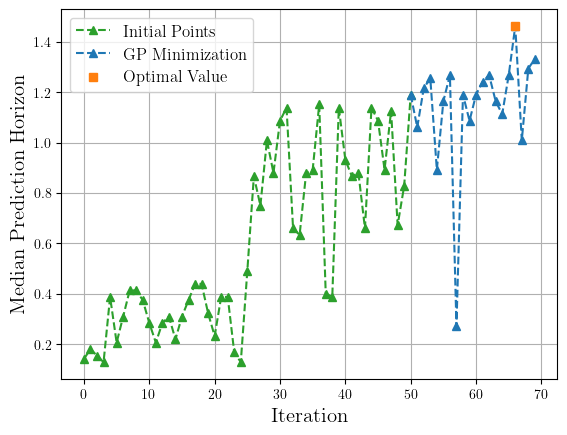

In [48]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.plot(
        -func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.plot(
    xplot,
    -func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.plot([optim_idx], [-func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Median Prediction Horizon', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/median_PH.pdf', bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

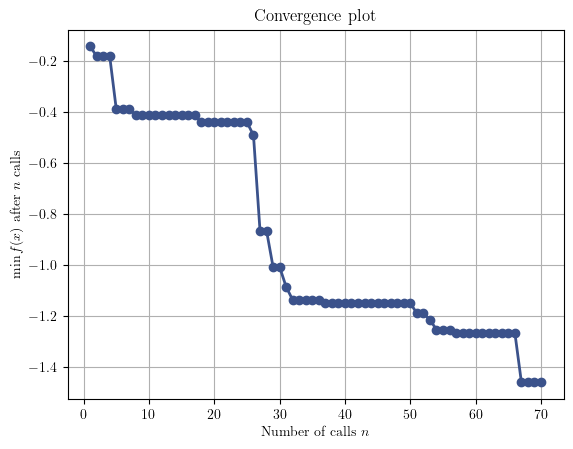

In [49]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [50]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_rnn+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_rnn+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

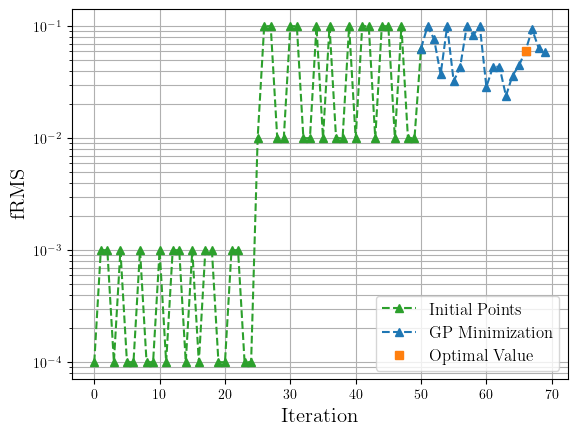

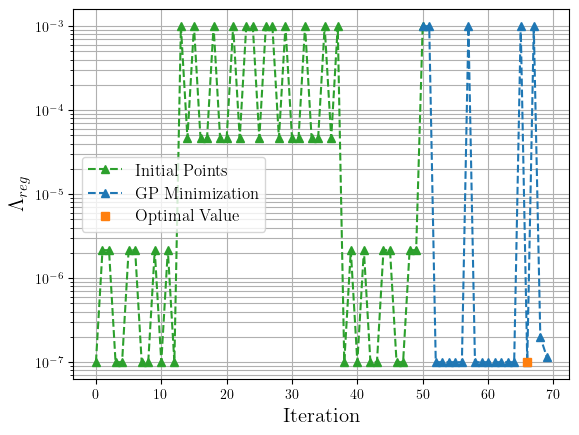

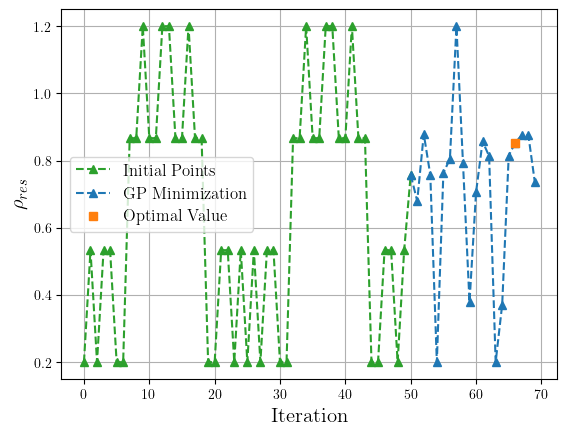

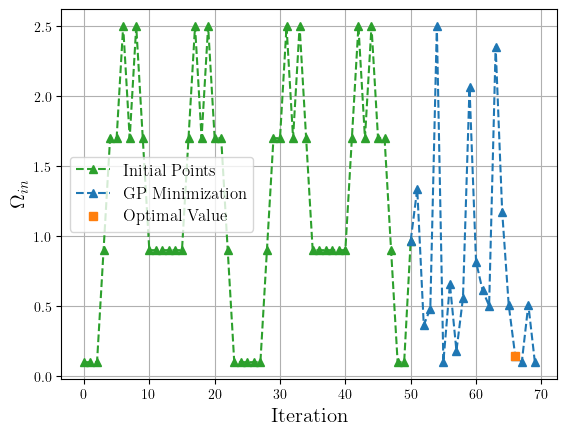

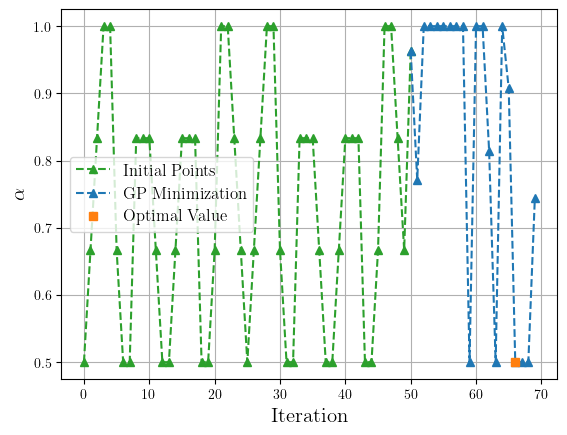

In [51]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\Lambda_{reg}$', 'lambda_reg', plt.semilogy],
    [r'$\rho_{res}$', 'rho_res', plt.plot],
    [r'$\Omega_{in}$', 'omega_in', plt.plot],
    [r'$\alpha$', 'alpha', plt.plot],
]
if vary_deg_connect == True:
    xoptim_names.append(
        [r'Degree of Connectivity', 'deg_of_connectivity', plt.plot]
    )

for i in range(len(xoptim_names)):
    a = n_initial_points + len(x0)
    # sorted_idx = np.argsort(x_iters[a:, 0])

    xplot = np.arange(x_iters.shape[0])
    if a > 0:
        xoptim_names[i][2](
            x_iters[:, i][0:a+1],
            linestyle='--',
            color='C2',
            marker='^',
            label='Initial Points',
        )
        xplot = np.arange(a, x_iters.shape[0])
    xoptim_names[i][2](
        xplot,
        x_iters[:, i][a:],
        linestyle='--',
        marker='^',
        label='GP Minimization',#'__nolegend__',
    )
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', label='Optimal Value')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(xoptim_names[i][0], fontsize=15)
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='both', axis='y')
    plt.legend(fontsize=12)

    plt.savefig(dir_name_rnn_plots+'/'+xoptim_names[i][1]+'.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [52]:
dir_list = os.listdir(dir_name_rnn+'/tested_rnn')
# dir_list

In [53]:
ph_mean_lst = []
for dir_name in dir_list:
    with np.load(dir_name_rnn+'/tested_rnn/'+dir_name+'/prediction_horizons-testingdata--combinedAERNN--ZEROoutsteps.npz') as f:
        ph_mean = np.mean(f['prediction_horizon_arr'])
        ph_mean_lst.append(ph_mean)
ph_mean_lst = np.array(ph_mean_lst)

In [54]:
idx = np.where(ph_mean_lst == ph_mean_lst.max())[0]

In [55]:
idx, dir_list[idx[0]]

(array([17]), 'test_rnn_066')

In [56]:
# convergence plot
convergence_f = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_f[i] = min_val

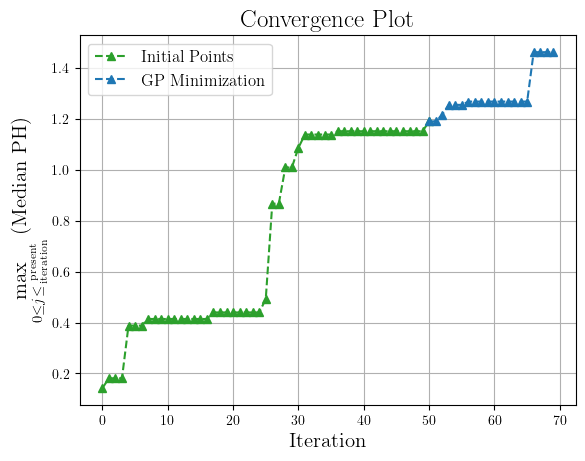

In [57]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.plot(
        -convergence_f[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.plot(
    xplot,
    -convergence_f[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
#     r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\max_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Median \ PH} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Prediction horizon computation